#### Bibliotecas e Base de Dados

In [28]:
import pandas as pd
import os
import math
from statsmodels.tsa.seasonal import STL
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from datetime import datetime
from sklearn.metrics import silhouette_score

%matplotlib inline
import matplotlib.pyplot as plt
# Carregar o dataframe tratado
df = pd.read_csv("base_tratada_lingualab.csv")


In [29]:
df

,ID_Cliente,Motivo,Education,Cidade,Renda_anual,Aulas,NPS,Num_Aulas,Ano_de_nascimento,Banheiros_na_casa,Quartos_na_casa,motivo_na,renda_na,Quartos_Banheiros,faixa_idade
0,0,Viagem,Graduação,São Paulo,58138.000000,Ingles,4,19,1983,3,4,False,False,4Q_3B,1980s
1,1,Trabalho,Graduação,Taubaté,46344.000000,Espanhol,4,10,1980,4,3,False,False,3Q_4B,1980s
2,3,Viagem,Graduação,São Paulo,20941.846715,Espanhol,4,22,2010,1,1,False,True,1Q_1B,2010s
3,4,Trabalho,Doutorado,São Paulo,58293.000000,Ingles,3,8,2007,3,4,False,False,4Q_3B,2000s
4,5,Trabalho,Mestrado,São Paulo,60704.888889,Espanhol,3,9,1993,4,4,False,True,4Q_4B,1990s
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2104,2234,Viagem,Graduação,São Paulo,34421.000000,Espanhol,4,13,2000,2,2,False,False,2Q_2B,2000s
2105,2235,Trabalho,Graduação,São Paulo,60704.888889,Espanhol e Ingles,4,12,1993,4,4,False,True,4Q_4B,1990s
2106,2237,Viagem,Graduação,São Paulo,56981.000000,Espanhol e Ingles,3,1,2007,3,4,False,False,4Q_3B,2000s
2107,2238,Trabalho,Mestrado,São Paulo,69245.000000,Ingles,4,14,1982,3,5,False,False,5Q_3B,1980s


In [30]:
df.describe()

,ID_Cliente,Renda_anual,NPS,Num_Aulas,Ano_de_nascimento,Banheiros_na_casa,Quartos_na_casa
count,2109.000000,2109.000000,2109.000000,2109.000000,2109.000000,2109.000000,2109.000000
mean,1124.458511,50987.339256,2.793267,16.349455,1995.576102,2.953532,3.415837
std,647.937902,20534.583248,1.185352,11.641006,11.581758,1.407395,1.721103
min,0.000000,1730.000000,1.000000,1.000000,1919.000000,1.000000,1.000000
25%,560.000000,34578.000000,2.000000,8.000000,1987.000000,2.000000,2.000000
50%,1125.000000,50737.000000,3.000000,13.000000,1997.000000,3.000000,3.000000
75%,1689.000000,67542.798658,4.000000,23.000000,2004.000000,4.000000,5.000000
max,2239.000000,105471.000000,5.000000,53.000000,2022.000000,5.000000,6.000000


# Analise Macro

#### PERFIL E SEGMENTAÇÃO DE CLIENTES

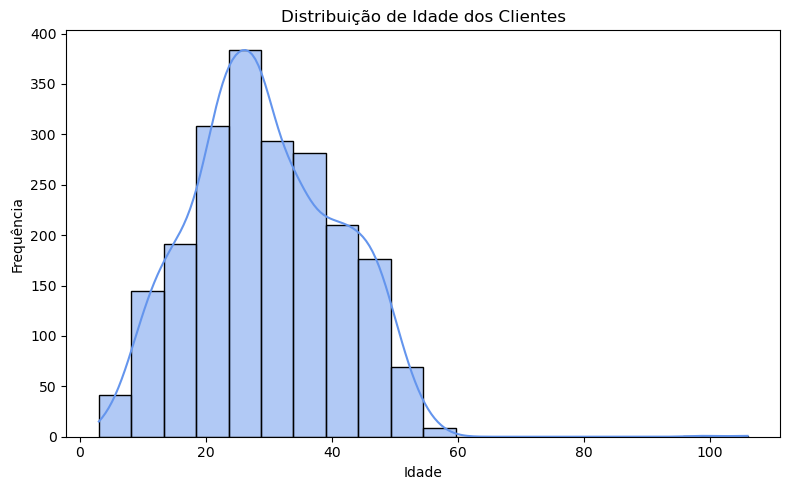

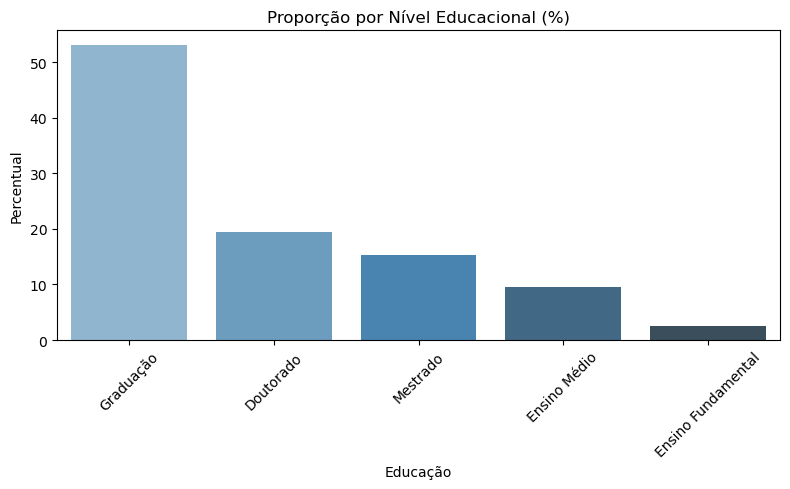

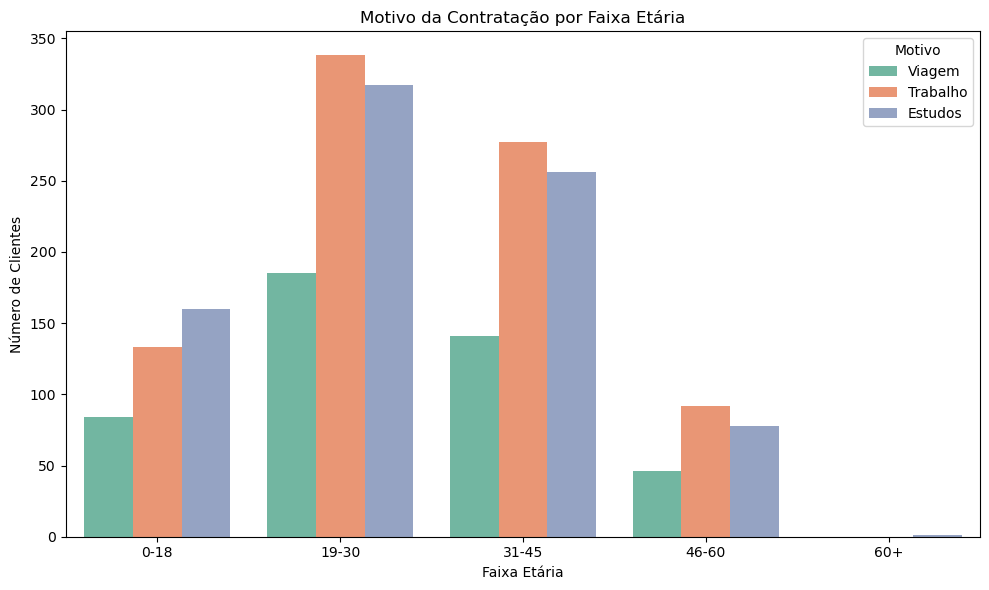

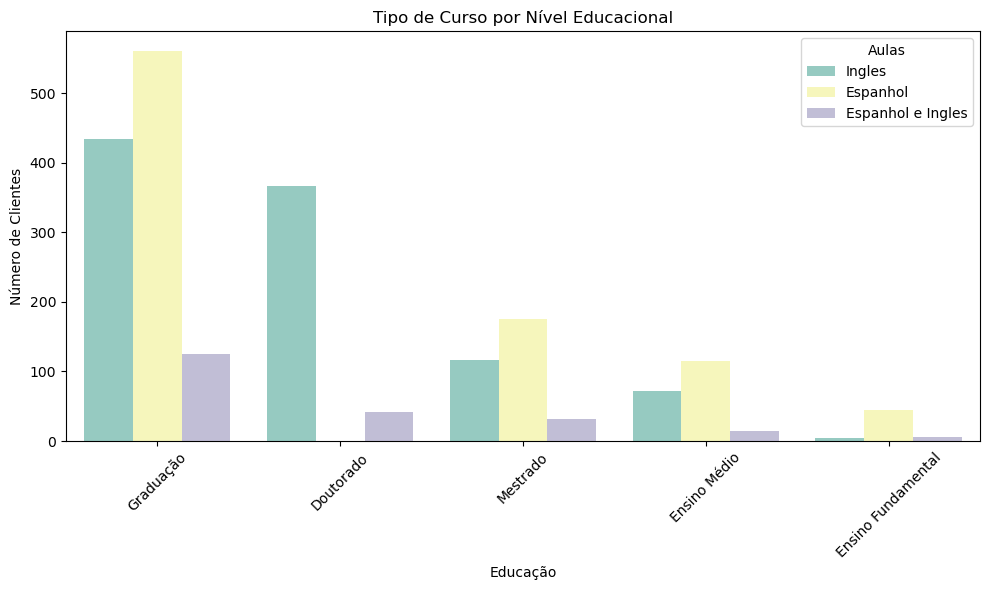

In [31]:

# Adicionando coluna de idade
current_year = datetime.now().year
df["Idade"] = current_year - df["Ano_de_nascimento"]

# Faixa etária
df["Faixa_Etaria"] = pd.cut(df["Idade"], bins=[0, 18, 30, 45, 60, 100],
                            labels=["0-18", "19-30", "31-45", "46-60", "60+"])


# Plot 1: Distribuição de idade (histograma)
plt.figure(figsize=(8, 5))
sns.histplot(df["Idade"], bins=20, kde=True, color="cornflowerblue")
plt.title("Distribuição de Idade dos Clientes")
plt.xlabel("Idade")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()

# Plot 2: Proporção por nível educacional
plt.figure(figsize=(8, 5))
edu_counts = df["Education"].value_counts(normalize=True).sort_values(ascending=False) * 100
sns.barplot(x=edu_counts.index, y=edu_counts.values, palette="Blues_d")
plt.title("Proporção por Nível Educacional (%)")
plt.ylabel("Percentual")
plt.xlabel("Educação")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 3: Motivo da contratação por faixa etária
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="Faixa_Etaria", hue="Motivo", palette="Set2")
plt.title("Motivo da Contratação por Faixa Etária")
plt.xlabel("Faixa Etária")
plt.ylabel("Número de Clientes")
plt.tight_layout()
plt.show()

# Plot 4: Tipo de curso por perfil educacional
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="Education", hue="Aulas", palette="Set3", order=edu_counts.index)
plt.title("Tipo de Curso por Nível Educacional")
plt.xlabel("Educação")
plt.ylabel("Número de Clientes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


clusterização com o algoritmo K-Means.

In [36]:


# Calcular a idade
df['Idade'] = datetime.now().year - df['Ano_de_nascimento']

# Converter 'Education' para formato ordinal
education_order = {
    'Ensino Fundamental': 1,
    'Ensino Médio': 2,
    'Graduação': 3,
    'Mestrado': 4,
    'Doutorado': 5
}
df['Edu_Ordinal'] = df['Education'].map(education_order)

# Selecionar variáveis para clusterização
cluster_df = df[['Idade', 'Renda_anual', 'Num_Aulas', 'NPS', 'Banheiros_na_casa', 'Quartos_na_casa', 'Edu_Ordinal']].copy()

# Padronizar os dados
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_df)

# Aplicar KMeans (4 clusters como exemplo)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(scaled_data)

# Gerar resumo por cluster
cluster_summary = df.groupby('Cluster').agg({
    'Edu_Ordinal': 'mean',
    'Idade': 'mean',
    'Renda_anual': 'mean',
    'Num_Aulas': 'mean',
    'NPS': 'mean',
    'ID_Cliente': 'count'
}).rename(columns={'ID_Cliente': 'Qtd_Clientes'})

# Exibir a tabela resumo
print("\nResumo por Cluster:")
print(cluster_summary.round(2))



Resumo por Cluster:
         Edu_Ordinal  Idade  Renda_anual  Num_Aulas   NPS  Qtd_Clientes
Cluster                                                                
0               3.38  31.06     71670.82      17.71  2.97           844
1               2.85  24.12     30843.16      10.73  2.32           724
2               4.15  33.97     45677.78      21.74  3.15           541


Validações da clusterizacao 

A inércia mede quão compactos os clusters estão. O gráfico mostra a inércia para diferentes valores de k (número de clusters). Quando a redução da inércia começa a diminuir (o “cotovelo”), esse é o número ideal de clusters.

Coeficiente de Silhueta (Silhouette Score)
Esse valor varia entre -1 e 1:
Próximo de 1: pontos estão bem dentro dos seus clusters;
Próximo de 0: pontos estão entre clusters;
Negativo: pontos podem estar em clusters errados.

Visualização em 2D com PCA
Reduzimos a base para 2 dimensões com PCA e plotamos os clusters. Se os grupos forem bem separados visualmente, isso valida a segmentação.

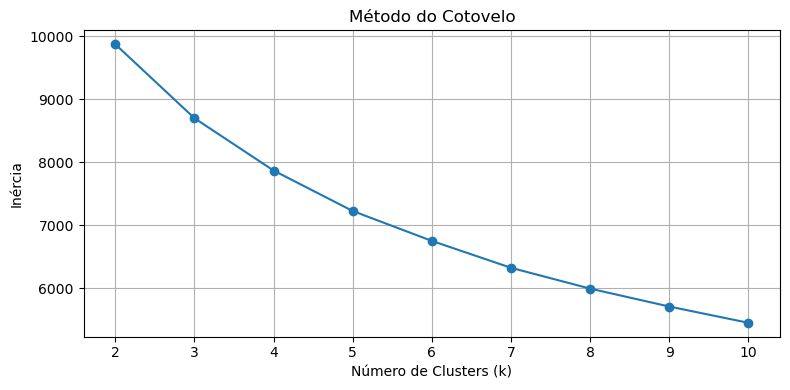


Silhouette Score para k=3: 0.2133


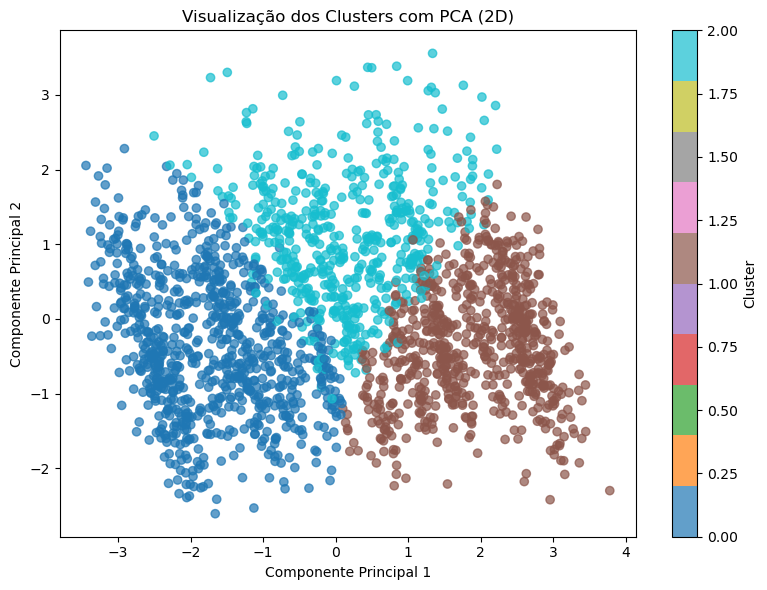

In [40]:


X = df[['Idade', 'Renda_anual', 'Num_Aulas', 'NPS', 'Banheiros_na_casa', 'Quartos_na_casa', 'Edu_Ordinal']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cotovelo
inertias = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), inertias, marker='o')
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.grid(True)
plt.tight_layout()
plt.show()

#Silhouette Score 
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
sil_score = silhouette_score(X_scaled, clusters)
print(f"\nSilhouette Score para k=3: {sil_score:.4f}")

# PCA 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10', alpha=0.7)
plt.title('Visualização dos Clusters com PCA (2D)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()



Cluster 0 – Profissionais adultos com renda alta e engajamento moderado (maior grupo)

Cluster 1 – Jovens em formação, baixa renda, menor escolaridade

Cluster 2 – Altamente educados, renda média, forte presença de mestrado/doutorado

Com k=4
Separava mais nuances (como renda alta com baixa aula vs. muita aula com mesma renda), mas isso sacrificava a separação geral entre grupos (Silhouette menor, PCA mais embaralhado).

#### Clusterização por DB Scan 

In [41]:
# from sklearn.cluster import DBSCAN
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA


# # Seleção e padronização
# X = df[['Idade', 'Renda_anual', 'Num_Aulas', 'NPS', 'Banheiros_na_casa', 'Quartos_na_casa', 'Edu_Ordinal']]
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Aplicar DBSCAN
# dbscan = DBSCAN(eps=1.3, min_samples=15)
# labels = dbscan.fit_predict(X_scaled)

# # Adicionar os rótulos ao DataFrame
# df['DBSCAN_Cluster'] = labels

# # Número de clusters encontrados (excluindo ruído)
# n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
# n_noise = list(labels).count(-1)
# print(f"Clusters encontrados: {n_clusters}")
# print(f"Outliers detectados: {n_noise}")

# # Visualização com PCA
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X_scaled)

# plt.figure(figsize=(10, 6))
# scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', alpha=0.7)
# plt.title('Clusters via DBSCAN (com outliers em -1)')
# plt.xlabel('Componente Principal 1')
# plt.ylabel('Componente Principal 2')
# plt.colorbar(scatter, label='Cluster')
# plt.tight_layout()
# plt.show()


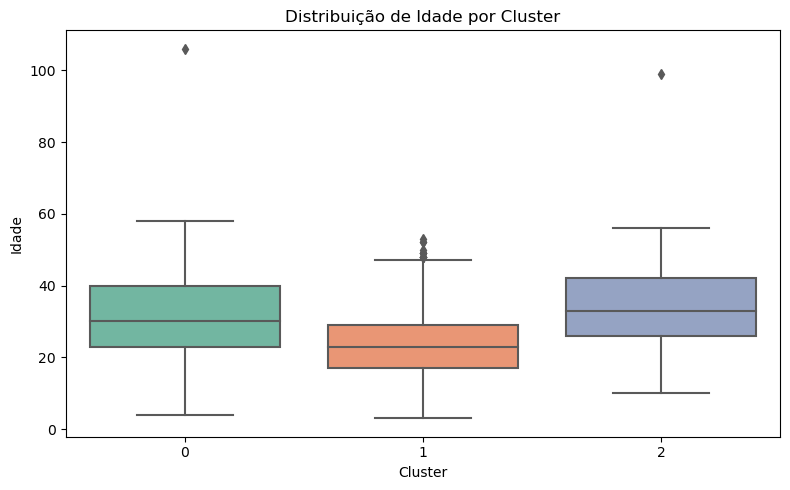

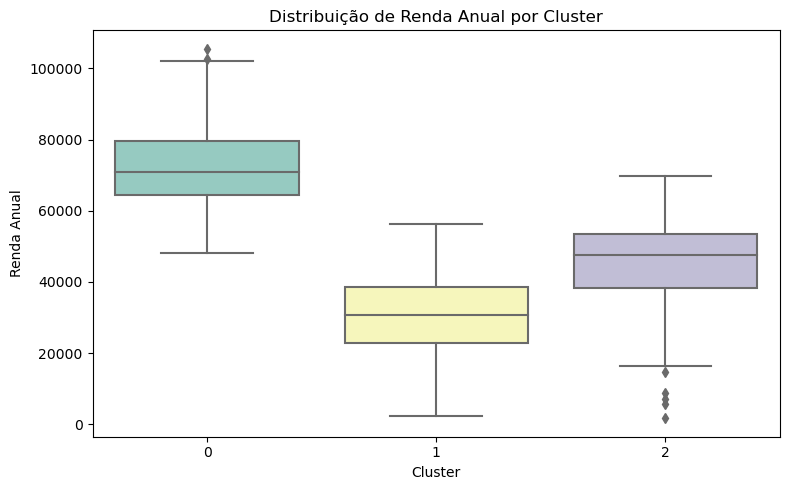

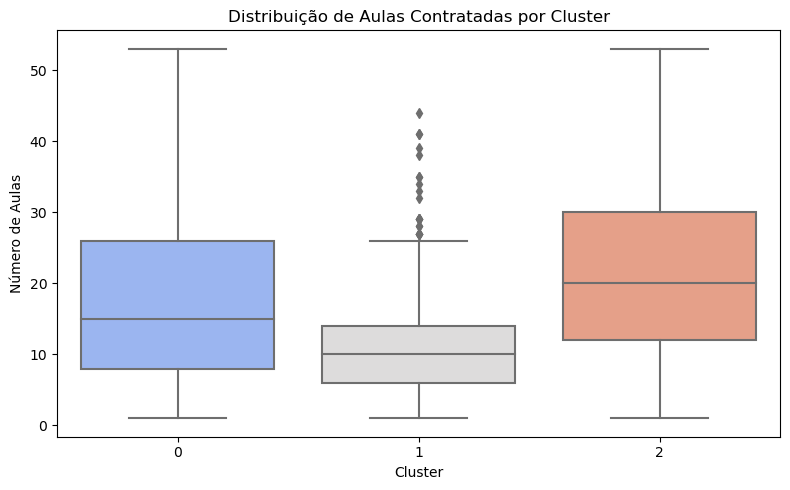

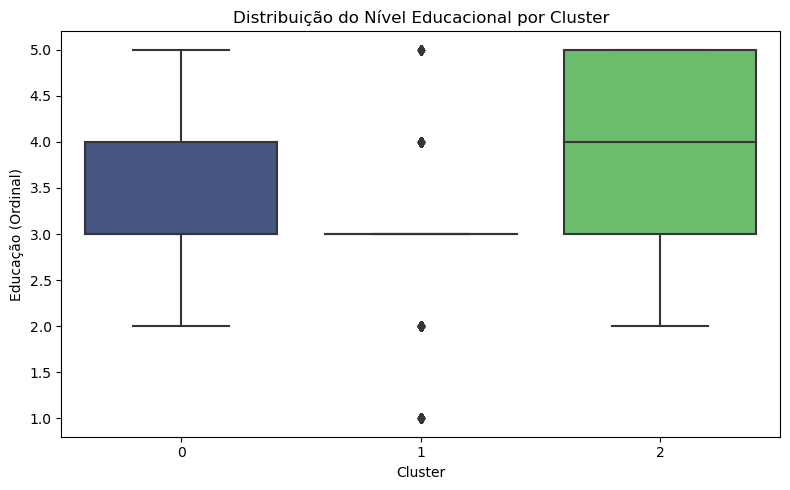

In [43]:

# Gráfico 1: Idade média por cluster
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Cluster', y='Idade', palette='Set2')
plt.title('Distribuição de Idade por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Idade')
plt.tight_layout()
plt.show()

# Gráfico 2: Renda média por cluster
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Cluster', y='Renda_anual', palette='Set3')
plt.title('Distribuição de Renda Anual por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Renda Anual')
plt.tight_layout()
plt.show()

# Gráfico 3: Número de aulas por cluster
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Cluster', y='Num_Aulas', palette='coolwarm')
plt.title('Distribuição de Aulas Contratadas por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Número de Aulas')
plt.tight_layout()
plt.show()

# Gráfico 4: Nível educacional (ordinal) por cluster
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Cluster', y='Edu_Ordinal', palette='viridis')
plt.title('Distribuição do Nível Educacional por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Educação (Ordinal)')
plt.tight_layout()
plt.show()


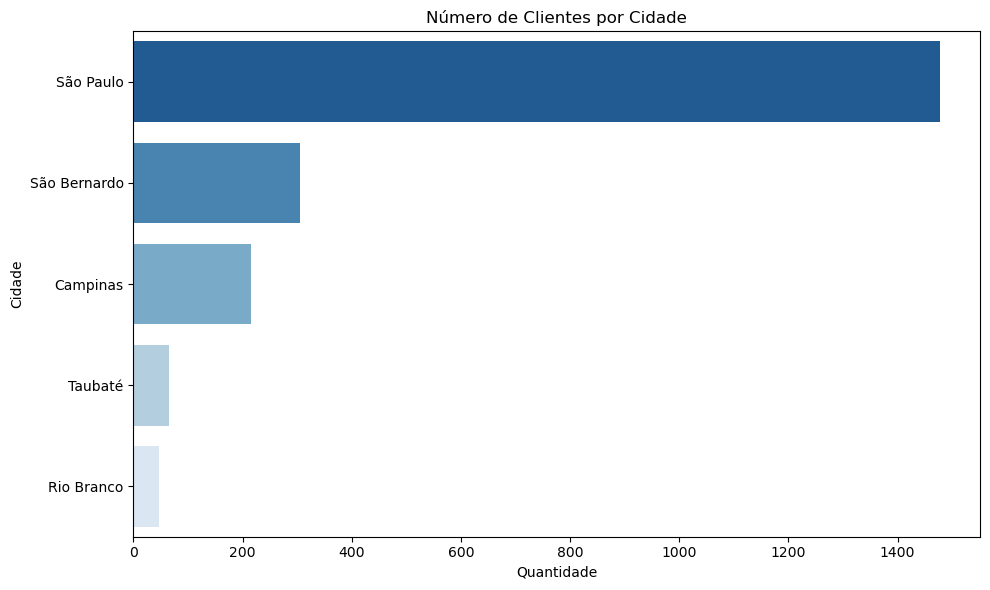

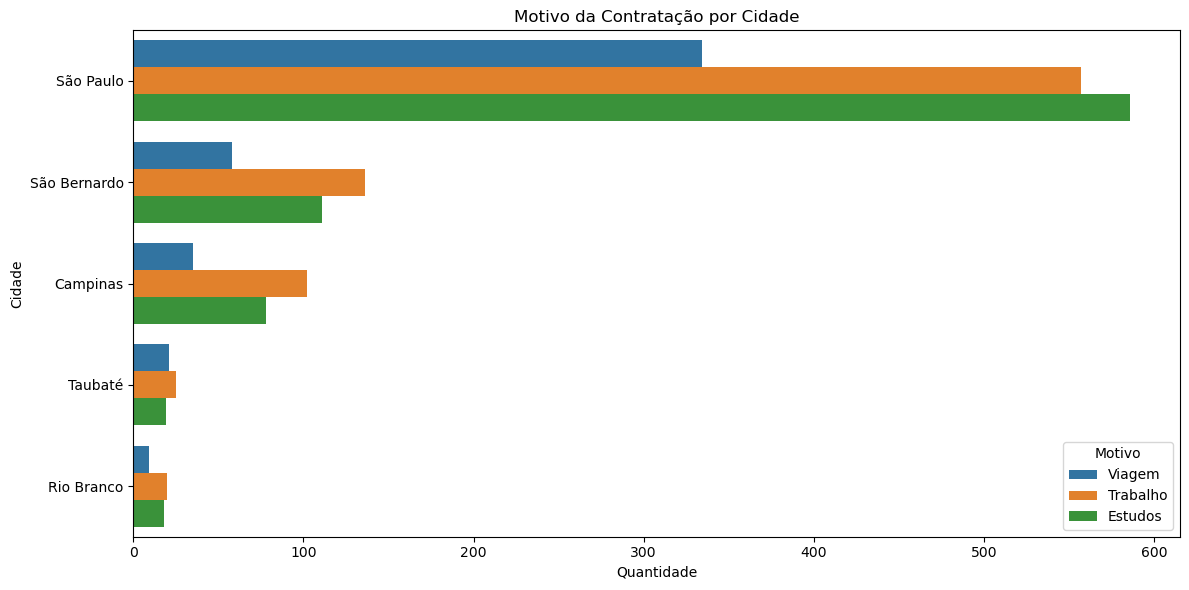

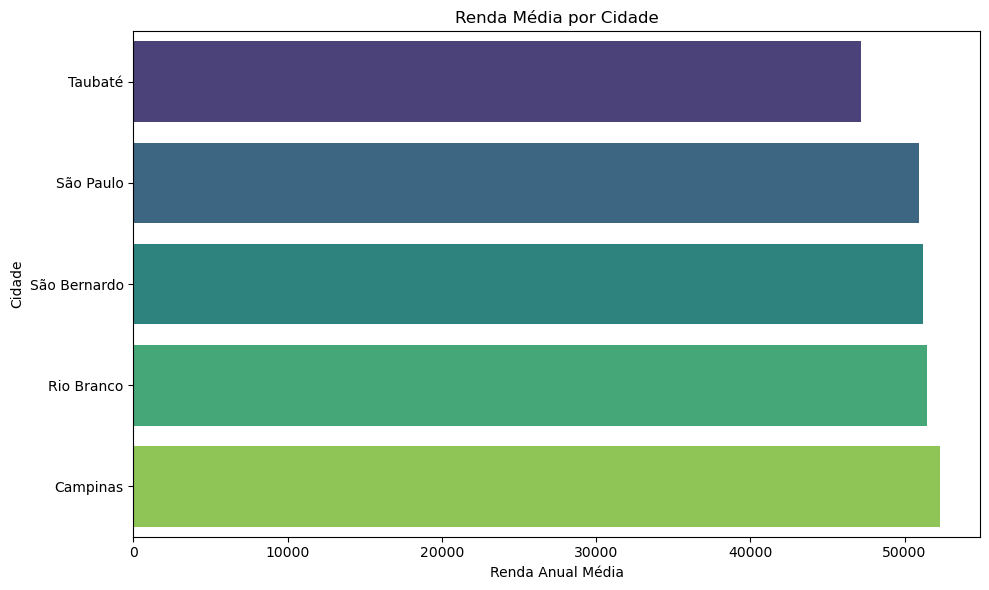

In [44]:
# Gráfico 1: Contagem absoluta de clientes por cidade
plt.figure(figsize=(10, 6))
cidade_order = df['Cidade'].value_counts().index
sns.countplot(data=df, y='Cidade', order=cidade_order, palette='Blues_r')
plt.title('Número de Clientes por Cidade')
plt.xlabel('Quantidade')
plt.ylabel('Cidade')
plt.tight_layout()
plt.show()

# Gráfico 2: Distribuição por Motivo dentro de cada cidade (proporcional)
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='Cidade', hue='Motivo', order=cidade_order)
plt.title('Motivo da Contratação por Cidade')
plt.xlabel('Quantidade')
plt.ylabel('Cidade')
plt.legend(title='Motivo')
plt.tight_layout()
plt.show()

# Gráfico 3: Renda média por cidade
renda_cidade = df.groupby('Cidade')['Renda_anual'].mean().sort_values()
plt.figure(figsize=(10, 6))
sns.barplot(x=renda_cidade.values, y=renda_cidade.index, palette='viridis')
plt.title('Renda Média por Cidade')
plt.xlabel('Renda Anual Média')
plt.ylabel('Cidade')
plt.tight_layout()
plt.show()

cruzar cluster com cidade?

In [48]:
# Tópico 4 — Poder Aquisitivo por Região (utilizando cidades como proxy de região)

# Calcular estatísticas de renda por cidade
renda_stats = df.groupby('Cidade')['Renda_anual'].agg(['mean', 'median', 'count', 'std']).sort_values('mean', ascending=False)
renda_stats = renda_stats.rename(columns={
    'mean': 'Renda Média',
    'median': 'Renda Mediana',
    'count': 'Qtd Clientes',
    'std': 'Desvio Padrão'
})

## Reexibir a tabela de forma compatível com o ambiente do usuário

renda_stats.reset_index(inplace=True)
renda_stats


,Cidade,Renda Média,Renda Mediana,Qtd Clientes,Desvio Padrão
0,Campinas,52278.814857,50785.0,215,20225.821415
1,Rio Branco,51462.870616,50116.0,47,20154.513148
2,São Bernardo,51172.561184,51124.0,305,20791.609706
3,São Paulo,50913.045999,50870.0,1477,20561.587128
4,Taubaté,47190.742709,48007.5,65,20111.521835


🔹 1. Perfil sociodemográfico dos clientes
Variáveis-chave:
Ano_de_nascimento → converter para idade
Education
Motivo (Viagem, Trabalho, Estudos)
Aulas (tipo de curso: Inglês, Espanhol, Mandarim etc.)
Análises recomendadas:
Distribuição de idade (histograma ou faixas etárias)
Proporção por nível educacional
Motivo da contratação por faixa etária
Tipo de curso por perfil educacional
🔹 2. Nível educacional médio por cluster
Estratégia:
Usar Education como variável categórica ordinal:
Ensino Fundamental = 1
Ensino Médio = 2
Graduação = 3
Mestrado = 4
Doutorado = 5
Realizar uma clusterização com KMeans ou agrupamento hierárquico usando variáveis como:
Idade
Número de aulas (Num_Aulas)
NPS
Renda
Quantidade de banheiros/quartos
Depois, calcular a média educacional por cluster (convertendo a categoria em número como acima)
🔹 3. Distribuição geográfica da base
Variável-chave:
Cidade
Análises sugeridas:
Contagem absoluta de clientes por cidade
Proporção relativa (porcentagem)
Distribuição por Motivo, Education ou Aulas dentro de cada cidade
Representar graficamente (gráfico de barras ou mapa, se possível)
🔹 4. Poder aquisitivo por região
Variáveis:
Cidade
Renda_anual
Análises recomendadas:
Média, mediana e desvio padrão da Renda_anual por cidade
Boxplot de Renda_anual por cidade
Cruzamento de renda com Education e Motivo dentro de cada cidade (para identificar perfis de alto ticket)
Detecção de outliers por cidade (ajuda na precificação e segmentação de campanhas)